##Descrizione e Processamento Dataset##

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data = pd.read_csv("/content/drive/MyDrive/Progetto Data Mining/20-21_plEventsData.csv")
data = pd.read_csv("/content/drive/MyDrive/Progetto Parente/20-21_plEventsData.csv")
print(data.info())

<ipython-input-2-027035877db7>:2: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/Progetto Parente/20-21_plEventsData.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607656 entries, 0 to 607655
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               607656 non-null  int64  
 1   id                       607656 non-null  float64
 2   eventId                  607656 non-null  int64  
 3   minute                   607656 non-null  int64  
 4   second                   606355 non-null  float64
 5   teamId                   607656 non-null  int64  
 6   x                        607656 non-null  float64
 7   y                        607656 non-null  float64
 8   expandedMinute           607656 non-null  int64  
 9   qualifiers               607656 non-null  object 
 10  satisfiedEventsTypes     607656 non-null  object 
 11  isTouch                  607656 non-null  bool   
 12  period_value             607656 non-null  int64  
 13  period_displayName       607656 non-null  object 
 14  type

Prima interpretazione delle colonne :

* **Unnamed**: 0: Probabilmente un indice generato
automaticamente durante l'esportazione del dataset. Può essere ignorato o rimosso.

* **id**: Identificatore unico per ogni evento. Serve per distinguere ogni riga del dataset.

* **eventId**: Codice numerico che rappresenta il tipo di evento (es. passaggio, tiro, fallo, ecc.). Sarà utile per identificare il tipo di azione.

* **minute**: Minuto della partita in cui si verifica l'evento.

* **second**: Secondo del minuto in cui si verifica l'evento.

* **teamId**: Identificatore della squadra coinvolta nell'evento. Serve per distinguere eventi tra squadre.

* **x, y**: Coordinate spaziali del campo in cui si è verificato l'evento. Potrebbero rappresentare la posizione iniziale (es. per un tiro o un passaggio).

* **expandedMinute**: Una versione più dettagliata del minuto (potrebbe includere tempo aggiuntivo, come 45+1 per il primo tempo).

* **qualifiers**: Un campo JSON o lista che descrive qualificatori aggiuntivi dell'evento (es. passaggio lungo, tiro di destro, ecc.).

* **satisfiedEventsTypes**: Tipologie di eventi "soddisfatti" da un'azione (potrebbe indicare eventi concatenati o che completano una sequenza).

* **isTouch**: Booleano che indica se l'evento riguarda un tocco di palla.

* **period_value**: Valore numerico del periodo di gioco (es. 1 = primo tempo, 2 = secondo tempo).

* **period_displayName**: Nome del periodo di gioco (es. "First Half", "Second Half").

* **type_value**: Valore numerico del tipo di evento (simile a eventId).

* **type_displayName**: Nome descrittivo del tipo di evento (es. "Pass", "Shot", "Foul").

* **outcomeType_value**: Valore numerico che rappresenta l'esito dell'evento (es. riuscito o fallito).

* **outcomeType_displayName**: Nome descrittivo dell'esito dell'evento (es. "Successful", "Unsuccessful").

* **playerId**: Identificatore del giocatore coinvolto nell'evento.

* **endX, endY**: Coordinate finali del campo per l'evento (es. destinazione di un passaggio o punto in cui termina un dribbling).

* **relatedEventId**: Riferimento ad altri eventi correlati (es. un passaggio potrebbe essere correlato a un tiro).

* **relatedPlayerId**: Identificatore di un giocatore correlato (es. il destinatario di un passaggio).

* **goalMouthZ, goalMouthY**: Coordinate specifiche per tiri in porta (posizione relativa alla porta avversaria).

* **isShot**: Booleano che indica se l'evento è un tiro.

* **blockedX, blockedY**: Coordinate in cui il tiro o passaggio è stato bloccato (se applicabile).

* **cardType_value**: Valore numerico che rappresenta il tipo di cartellino (es. giallo, rosso).

* **cardType_displayName**: Nome descrittivo del tipo di cartellino (es. "Yellow Card", "Red Card").

* **isGoal**: Booleano che indica se l'evento ha portato a un gol.

* **name**: Nome del giocatore.

* **position**: Posizione del giocatore in campo (es. "Defender", "Midfielder").

* **shirtNo**: Numero di maglia del giocatore.

* **isOwnGoal**: Booleano che indica se l'evento è un autogol.

In [ ]:
# Numero di squadre nel dataset
print("premier league teams: ", len(pd.unique(data["teamId"])))

premier league teams:  20


**COSTRUZIONE COLONNA MATCH ID PER IDENTIFICARE LE PARTITE**

In [ ]:
start_match_idxs = data.loc[data["type_displayName"] == "FormationSet",:].index
## formation set = 2 osservazioni all'inizio di ogni partita
print("number of matches in a season: ", len(start_match_idxs)/2)

number of matches in a season:  380.0


In [ ]:
#Indici dove troviamo FormationSet
start_match_idxs

Index([  1549,   1550,   3103,   3104,   4679,   4680,   6327,   6328,   7990,
         7991,
       ...
       601312, 601313, 602953, 602954, 604573, 604574, 606028, 606029, 607654,
       607655],
      dtype='int64', length=760)

In [ ]:
#Andiamo a dividere gli indici per ogni partita grazie a FormationSet
idxs_to_append = []
for idx, rec in enumerate(start_match_idxs):
    if idx == 0:
        idxs_to_append.append(np.arange(0,start_match_idxs[idx]))
    if len(np.arange(start_match_idxs[idx-1],rec)) > 1:
        idxs_to_append.append(np.arange(start_match_idxs[idx-1],rec))
    else:
        continue
print(len(idxs_to_append))

380


In [ ]:
#Indici che appartegono alle singole partite
idxs_to_append

[array([   0,    1,    2, ..., 1546, 1547, 1548]),
 array([1550, 1551, 1552, ..., 3100, 3101, 3102]),
 array([3104, 3105, 3106, ..., 4676, 4677, 4678]),
 array([4680, 4681, 4682, ..., 6324, 6325, 6326]),
 array([6328, 6329, 6330, ..., 7987, 7988, 7989]),
 array([7991, 7992, 7993, ..., 9725, 9726, 9727]),
 array([ 9729,  9730,  9731, ..., 11246, 11247, 11248]),
 array([11250, 11251, 11252, ..., 12725, 12726, 12727]),
 array([12729, 12730, 12731, ..., 14304, 14305, 14306]),
 array([14308, 14309, 14310, ..., 15868, 15869, 15870]),
 array([15872, 15873, 15874, ..., 17528, 17529, 17530]),
 array([17532, 17533, 17534, ..., 18924, 18925, 18926]),
 array([18928, 18929, 18930, ..., 20779, 20780, 20781]),
 array([20783, 20784, 20785, ..., 22514, 22515, 22516]),
 array([22518, 22519, 22520, ..., 24183, 24184, 24185]),
 array([24187, 24188, 24189, ..., 25751, 25752, 25753]),
 array([25755, 25756, 25757, ..., 27397, 27398, 27399]),
 array([27401, 27402, 27403, ..., 28777, 28778, 28779]),
 array([28

In [ ]:
#In base agli indici trovati creaiamo la colonna match_id
for idx, indexes in enumerate(idxs_to_append):
    data.loc[indexes, "match_id"] = f"MATCH_{idx + 1}"

In [ ]:
data.head(5)

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,qualifiers,...,blockedX,blockedY,cardType_value,cardType_displayName,isGoal,name,position,shirtNo,isOwnGoal,match_id
0,0,2.253487e+09,2,0,0.0,32,0.0,0.0,0,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MATCH_1
1,1,2.253487e+09,1000003,0,0.0,184,0.0,0.0,0,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MATCH_1
2,2,2.253488e+09,1000004,0,0.0,184,50.3,50.3,0,"[{'type': {'value': 213, 'displayName': 'Angle...",...,NaN,NaN,NaN,NaN,NaN,Ashley Westwood,MC,18.0,NaN,MATCH_1
3,3,2.253488e+09,1000005,0,2.0,184,29.6,53.4,0,"[{'type': {'value': 178, 'displayName': 'Stand...",...,NaN,NaN,NaN,NaN,NaN,James Tarkowski,DC,5.0,NaN,MATCH_1
4,4,2.253488e+09,1000006,0,7.0,184,41.3,18.4,0,"[{'type': {'value': 1, 'displayName': 'Longbal...",...,NaN,NaN,NaN,NaN,NaN,Matthew Lowton,DR,2.0,NaN,MATCH_1


In [ ]:
# Eventi non inclusi nel partizionamento delle partite (Eventi Pre-Match)
print("eventi esclusi: \n", np.unique(data.loc[data["match_id"].isna() , "period_displayName" ],return_counts=True))


eventi esclusi: 
 (array(['PreMatch'], dtype=object), array([381]))


In [ ]:
# Valori NaN in match_id
data.dropna(axis=0,subset="match_id", inplace=True)

In [ ]:
# Check match_id
np.unique(data["match_id"],return_counts=True)

(array(['MATCH_1', 'MATCH_10', 'MATCH_100', 'MATCH_101', 'MATCH_102',
        'MATCH_103', 'MATCH_104', 'MATCH_105', 'MATCH_106', 'MATCH_107',
        'MATCH_108', 'MATCH_109', 'MATCH_11', 'MATCH_110', 'MATCH_111',
        'MATCH_112', 'MATCH_113', 'MATCH_114', 'MATCH_115', 'MATCH_116',
        'MATCH_117', 'MATCH_118', 'MATCH_119', 'MATCH_12', 'MATCH_120',
        'MATCH_121', 'MATCH_122', 'MATCH_123', 'MATCH_124', 'MATCH_125',
        'MATCH_126', 'MATCH_127', 'MATCH_128', 'MATCH_129', 'MATCH_13',
        'MATCH_130', 'MATCH_131', 'MATCH_132', 'MATCH_133', 'MATCH_134',
        'MATCH_135', 'MATCH_136', 'MATCH_137', 'MATCH_138', 'MATCH_139',
        'MATCH_14', 'MATCH_140', 'MATCH_141', 'MATCH_142', 'MATCH_143',
        'MATCH_144', 'MATCH_145', 'MATCH_146', 'MATCH_147', 'MATCH_148',
        'MATCH_149', 'MATCH_15', 'MATCH_150', 'MATCH_151', 'MATCH_152',
        'MATCH_153', 'MATCH_154', 'MATCH_155', 'MATCH_156', 'MATCH_157',
        'MATCH_158', 'MATCH_159', 'MATCH_16', 'MATCH_160', 

In [ ]:
# Drop dei restanti eventi prematch e postmatch
data = data.loc[~data["period_displayName"].isin(["PreMatch","PostGame"]), : ]

In [ ]:
sorted_data = data.sort_values(by = "id")
sorted_data[["match_id", "minute","period_displayName"]]

,match_id,minute,period_displayName
4682,MATCH_4,0,FirstHalf
4681,MATCH_4,0,FirstHalf
4683,MATCH_4,0,FirstHalf
4684,MATCH_4,0,FirstHalf
4685,MATCH_4,0,FirstHalf
...,...,...,...
598124,MATCH_374,89,SecondHalf
598125,MATCH_374,89,SecondHalf
598126,MATCH_374,89,SecondHalf
598127,MATCH_374,89,SecondHalf


**Features Engineering**

In [ ]:
# Array di match_id in ordine cronologico
match_ids_sorted = sorted_data["match_id"].unique()

# Crea una mappatura: match_id originale -> nuovo match_id
new_match_ids = {old_id: f"MATCH_{new_id + 1}" for new_id, old_id in enumerate(match_ids_sorted)}

# Sostituisci i vecchi match_id con i nuovi nel dataset
sorted_data["match_id"] = sorted_data["match_id"].map(new_match_ids)

# Verifica il risultato
print(sorted_data["match_id"].unique())

['MATCH_1' 'MATCH_2' 'MATCH_3' 'MATCH_4' 'MATCH_5' 'MATCH_6' 'MATCH_7'
 'MATCH_8' 'MATCH_9' 'MATCH_10' 'MATCH_11' 'MATCH_12' 'MATCH_13'
 'MATCH_14' 'MATCH_15' 'MATCH_16' 'MATCH_17' 'MATCH_18' 'MATCH_19'
 'MATCH_20' 'MATCH_21' 'MATCH_22' 'MATCH_23' 'MATCH_24' 'MATCH_25'
 'MATCH_26' 'MATCH_27' 'MATCH_28' 'MATCH_29' 'MATCH_30' 'MATCH_31'
 'MATCH_32' 'MATCH_33' 'MATCH_34' 'MATCH_35' 'MATCH_36' 'MATCH_37'
 'MATCH_38' 'MATCH_39' 'MATCH_40' 'MATCH_41' 'MATCH_42' 'MATCH_43'
 'MATCH_44' 'MATCH_45' 'MATCH_46' 'MATCH_47' 'MATCH_48' 'MATCH_49'
 'MATCH_50' 'MATCH_51' 'MATCH_52' 'MATCH_53' 'MATCH_54' 'MATCH_55'
 'MATCH_56' 'MATCH_57' 'MATCH_58' 'MATCH_59' 'MATCH_60' 'MATCH_61'
 'MATCH_62' 'MATCH_63' 'MATCH_64' 'MATCH_65' 'MATCH_66' 'MATCH_67'
 'MATCH_68' 'MATCH_69' 'MATCH_70' 'MATCH_71' 'MATCH_72' 'MATCH_73'
 'MATCH_74' 'MATCH_75' 'MATCH_76' 'MATCH_77' 'MATCH_78' 'MATCH_79'
 'MATCH_80' 'MATCH_81' 'MATCH_82' 'MATCH_83' 'MATCH_84' 'MATCH_85'
 'MATCH_86' 'MATCH_87' 'MATCH_88' 'MATCH_89' 'MATCH_90' 'MAT

**CREAZIONE DELLA COLONNA TEAM NAME E MAPPING DEGLI ID DELLE SQUADRE**

In [ ]:
# Dizionario di mapping tra teamId e nome della squadra
team_mapping = {
    13: "Arsenal", 170: "Fullham", 18: "Southampton", 162: "Crystal Palace",
    26: "Liverpool", 19: "Leeds", 23: "Newcastle", 29: "West Ham",
    14: "Leicester", 175: "West Bromwich Albion", 30: "Tottenham", 31: "Everton",
    161: "Wolves", 163: "Sheffield United", 15: "Chelsea", 211: "Brighton",
    167: "Manchester City", 32: "Manchester United", 184: "Burnley", 24: "Aston Villa"
}

# Creare una nuova colonna 'team_name' mappando i teamId ai nomi e convertendo in stringa
sorted_data["team_name"] = sorted_data["teamId"].map(team_mapping).astype(str)

In [ ]:
# Esempio di ricerca di una partita per match id
sorted_data[sorted_data["match_id"] == "MATCH_1"].groupby(by=["match_id", "team_name"])["isGoal"].sum()

match_id  team_name
MATCH_1   Arsenal      3
          Fullham      0
Name: isGoal, dtype: object

In [ ]:
# Marcatori nella partita per match_id
sorted_data[sorted_data["match_id"] == "MATCH_1"][sorted_data["isGoal"]==True][["name","expandedMinute"]]

<ipython-input-18-622f3250e798>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sorted_data[sorted_data["match_id"] == "MATCH_1"][sorted_data["isGoal"]==True][["name","expandedMinute"]]


,name,expandedMinute
4861,Alexandre Lacazette,7
5588,Gabriel Magalhães,50
5704,Pierre-Emerick Aubameyang,58


**FORMATTAZIONE DELLE VARIABILI IN NUMERICHE E CATEGORIALI**

In [ ]:
sorted_data["isOwnGoal_bin"] = 0
sorted_data.loc[sorted_data["isOwnGoal"].notna(),"isOwnGoal_bin"] = -1

sorted_data["isGoal_bin"] = 0
sorted_data.loc[data["isGoal"].notna(), "isGoal_bin"] = 1

In [ ]:
# Totale goal in un anno
data["isGoal_bin"].sum()

1024

In [ ]:
grouped_match = sorted_data.groupby(by = ["match_id","team_name","isOwnGoal_bin"])["isGoal_bin"].sum().reset_index()
grouped_match["adjusted_goals"] = grouped_match["isOwnGoal_bin"] + grouped_match["isGoal_bin"]
grouped_match

,match_id,team_name,isOwnGoal_bin,isGoal_bin,adjusted_goals
0,MATCH_1,Arsenal,0,3,3
1,MATCH_1,Fullham,0,0,0
2,MATCH_10,Fullham,0,3,3
3,MATCH_10,Leeds,0,4,4
4,MATCH_100,Fullham,0,0,0
...,...,...,...,...,...
792,MATCH_97,Leicester,0,1,1
793,MATCH_98,Aston Villa,0,1,1
794,MATCH_98,West Ham,0,2,2
795,MATCH_99,Burnley,0,1,1


In [ ]:
def get_match_result(score):
    # score = score.reset_index()
    score["points"] = 0

    if (score["isOwnGoal_bin"] != 0).any():
        # print("own goal")
        own_goal_team = score.loc[score["isOwnGoal_bin"] < 0, "team_name"]
        # print("own_goal_team", own_goal_team)
        score.loc[~score["team_name"].isin(own_goal_team), "adjusted_goals"] += 1

    goals = score.groupby("team_name")["adjusted_goals"].sum().reset_index()["adjusted_goals"]

    if goals.iloc[0] == goals.iloc[1]:  # Draw
        score["points"] = 1
        return score

    # Assign 3 points to the team with the highest adjusted goals
    score.loc[score["adjusted_goals"].idxmax(), "points"] = 3

    # print("score = ", score)
    return score

# Applying the function to grouped matches
results_with_points = grouped_match.groupby("match_id").apply(get_match_result).reset_index(drop=True)

<ipython-input-23-6f00cb8ffe4d>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_with_points = grouped_match.groupby("match_id").apply(get_match_result).reset_index(drop=True)


In [ ]:
classifica = results_with_points.groupby(by = "team_name")["adjusted_goals"].sum().sort_values(ascending=False)
classifica.head(5)

,adjusted_goals
team_name,
Manchester City,83
Manchester United,73
Liverpool,68
Leicester,68
Tottenham,68


##Esplorazione dei dati##

**Classifica Marcatori**

In [ ]:
players_goals = data.groupby(by = "name")["isGoal_bin"].sum()
players_goals = players_goals.sort_values(ascending=False)
players_goals.head(15)

,isGoal_bin
name,
Harry Kane,23
Mohamed Salah,22
Bruno Fernandes,18
Patrick Bamford,17
Son Heung-Min,17
Dominic Calvert-Lewin,16
Jamie Vardy,15
Ollie Watkins,14
Ilkay Gündogan,13


In [ ]:
#Conteggio eventi nel dataset ('type_displayName')
type_value_counts = sorted_data['type_displayName'].value_counts()
print(type_value_counts)

type_displayName
Pass               391325
BallRecovery        39690
BallTouch           25034
Aerial              24856
Foul                16566
Clearance           14514
TakeOn              13445
Tackle              11801
Interception         7833
CornerAwarded        7746
Challenge            7220
Dispossessed         6628
BlockedPass          5691
KeeperPickup         4917
SavedShot            4774
Save                 4738
MissedShots          3225
SubstitutionOn       2033
SubstitutionOff      2033
End                  1520
Start                1520
OffsidePass          1301
OffsideProvoked      1301
OffsideGiven         1301
Card                 1162
Goal                 1024
FormationChange       793
Claim                 502
ShieldBallOpp         337
Punch                 308
Error                 290
KeeperSweeper         238
ShotOnPost            209
PenaltyFaced          125
Smother                53
GoodSkill              49
ChanceMissed           23
CrossNotClaimed      

**Analisi Eventi**

<Axes: xlabel='type_displayName'>

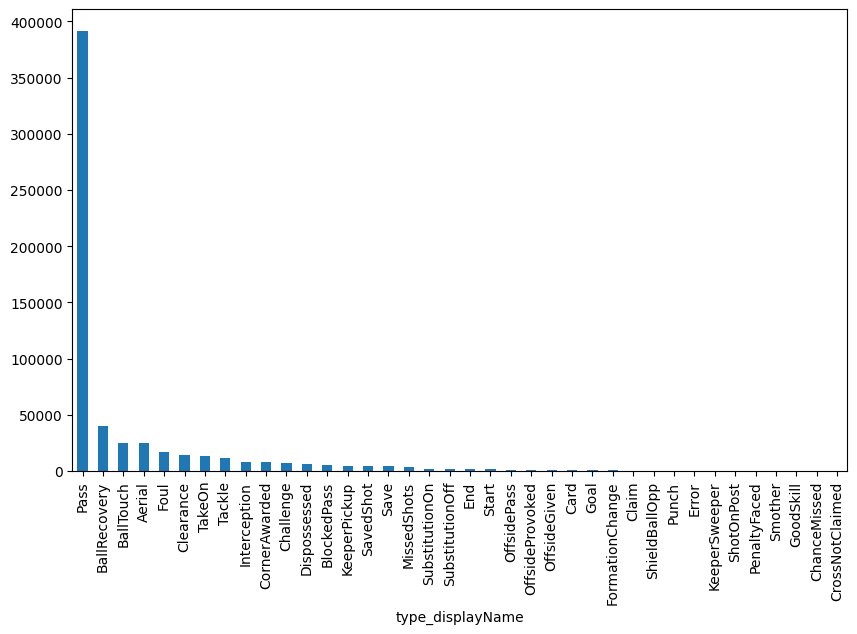

In [ ]:
# Grafico a barre dei conteggi (Con Pass)
import matplotlib.pyplot as plt
type_value_counts.plot(kind='bar', figsize=(10, 6))

<Axes: xlabel='type_displayName'>

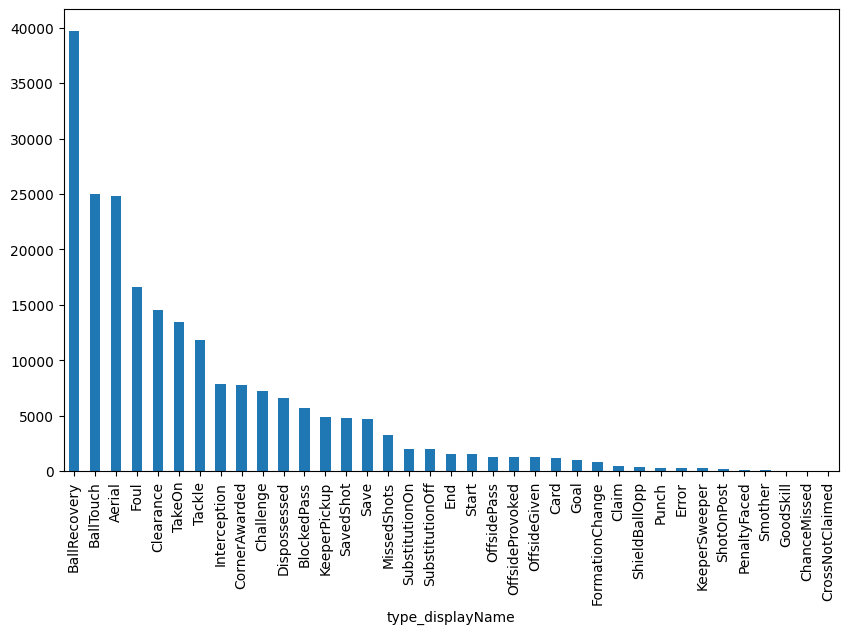

In [ ]:
# Grafico a barre dei conteggi senza "pass"
type_value_counts[1:].plot(kind='bar', figsize=(10, 6))

**Confronto Prime due Classificate**

In [ ]:
# Conteggio di type_value per ManCity
type_value_counts_per_team = sorted_data.groupby(['team_name', 'type_displayName']).size().reset_index(name='count')

team_1_data = type_value_counts_per_team[type_value_counts_per_team['team_name'] == 'Manchester City']

selected_events = ['BallTouch', 'Foul',"Tackle","CornerAwarded",'Save','MissedShots','Goal']

filtered_team_1_data = team_1_data[team_1_data['type_displayName'].isin(selected_events)]

print(filtered_team_1_data)

           team_name type_displayName  count
406  Manchester City        BallTouch   1122
413  Manchester City    CornerAwarded    359
418  Manchester City             Foul    751
419  Manchester City             Goal     83
424  Manchester City      MissedShots    190
431  Manchester City             Save    151
439  Manchester City           Tackle    498


In [ ]:
# Conteggio di type_value per Man United
team_2_data = type_value_counts_per_team[type_value_counts_per_team['team_name'] == 'Manchester United']

selected_events = ['BallTouch', 'Foul',"Tackle","CornerAwarded",'Save','MissedShots','Goal']

filtered_team_2_data = team_2_data[team_2_data['type_displayName'].isin(selected_events)]

print(filtered_team_2_data)

             team_name type_displayName  count
443  Manchester United        BallTouch   1230
449  Manchester United    CornerAwarded    360
454  Manchester United             Foul    864
455  Manchester United             Goal     72
460  Manchester United      MissedShots    158
467  Manchester United             Save    217
474  Manchester United           Tackle    551


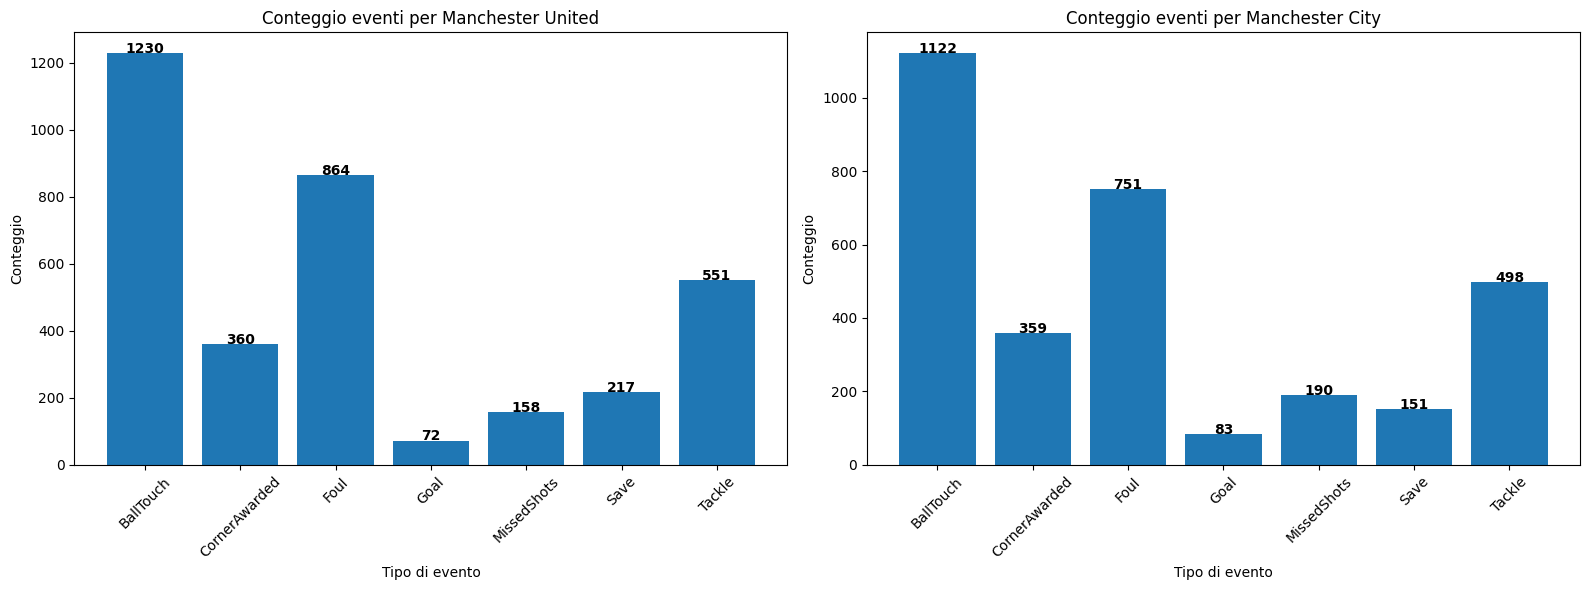

In [ ]:
# Grafico che confronta gli eventi per le prime due classificate
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 riga, 2 colonne

# Grafico per il Manchester United
axes[0].bar(filtered_team_2_data['type_displayName'], filtered_team_2_data['count'])
axes[0].set_ylabel('Conteggio')
axes[0].set_xlabel('Tipo di evento')
axes[0].set_title('Conteggio eventi per Manchester United')
axes[0].tick_params(axis='x', rotation=45)

# Aggiungi i numeri sopra ogni barra
for i, value in enumerate(filtered_team_2_data['count']):
    axes[0].text(i, value + 1, str(value), ha='center', fontsize=10, fontweight='bold')

# Grafico per il Manchester City
axes[1].bar(filtered_team_1_data['type_displayName'], filtered_team_1_data['count'])
axes[1].set_ylabel('Conteggio')
axes[1].set_xlabel('Tipo di evento')
axes[1].set_title('Conteggio eventi per Manchester City')
axes[1].tick_params(axis='x', rotation=45)

# Aggiungi i numeri sopra ogni barra
for i, value in enumerate(filtered_team_1_data['count']):
    axes[1].text(i, value + 1, str(value), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()



**Analisi Tiri e Goal per ogni squadra**

In [ ]:
# Filtra i dati per MissedShots e Goal
missed_shots_goals = sorted_data[sorted_data['type_displayName'].isin(['MissedShots', 'Goal'])]

missed_shots_goals_counts = missed_shots_goals.groupby(['team_name', 'type_displayName']).size().reset_index(name='count')

<ipython-input-33-1da0b6bd53ca>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


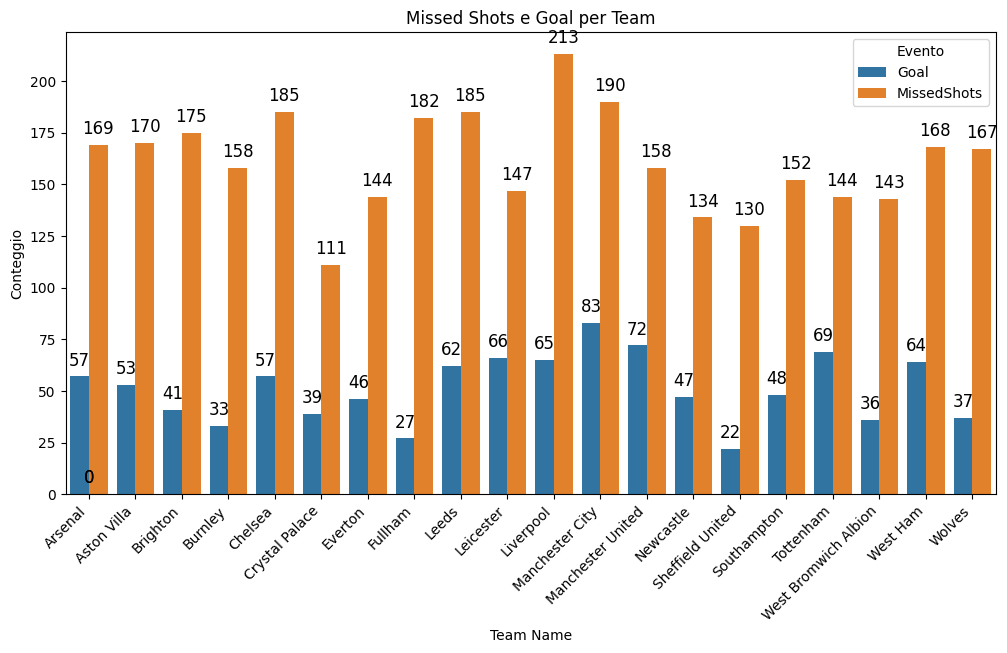

In [ ]:
# Confronto MissedShots e Goal per tutte le squadre
import seaborn as sns


plt.figure(figsize=(12, 6))
ax = sns.barplot(data=missed_shots_goals_counts, x='team_name', y='count', hue='type_displayName')
plt.title('Missed Shots e Goal per Team')
plt.xlabel('Team Name')
plt.ylabel('Conteggio')
plt.legend(title='Evento')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Aggiungi i numeri sopra le barre
for p in ax.patches:  # p è ogni barra
    ax.annotate(
        f'{p.get_height():.0f}',  # Il conteggio sopra la barra
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Posizione della barra
        ha='center',  # Allineamento orizzontale
        va='bottom',  # Allineamento verticale (usa 'bottom' o 'top')
        fontsize=12,  # Dimensione del testo
        color='black',  # Colore del testo
        xytext=(0, 5),  # Distanza del testo dalla barra
        textcoords='offset points'  # Coordina il testo rispetto alla barra
    )


plt.show()

In [ ]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 2.4 MB/s eta 0:00:00


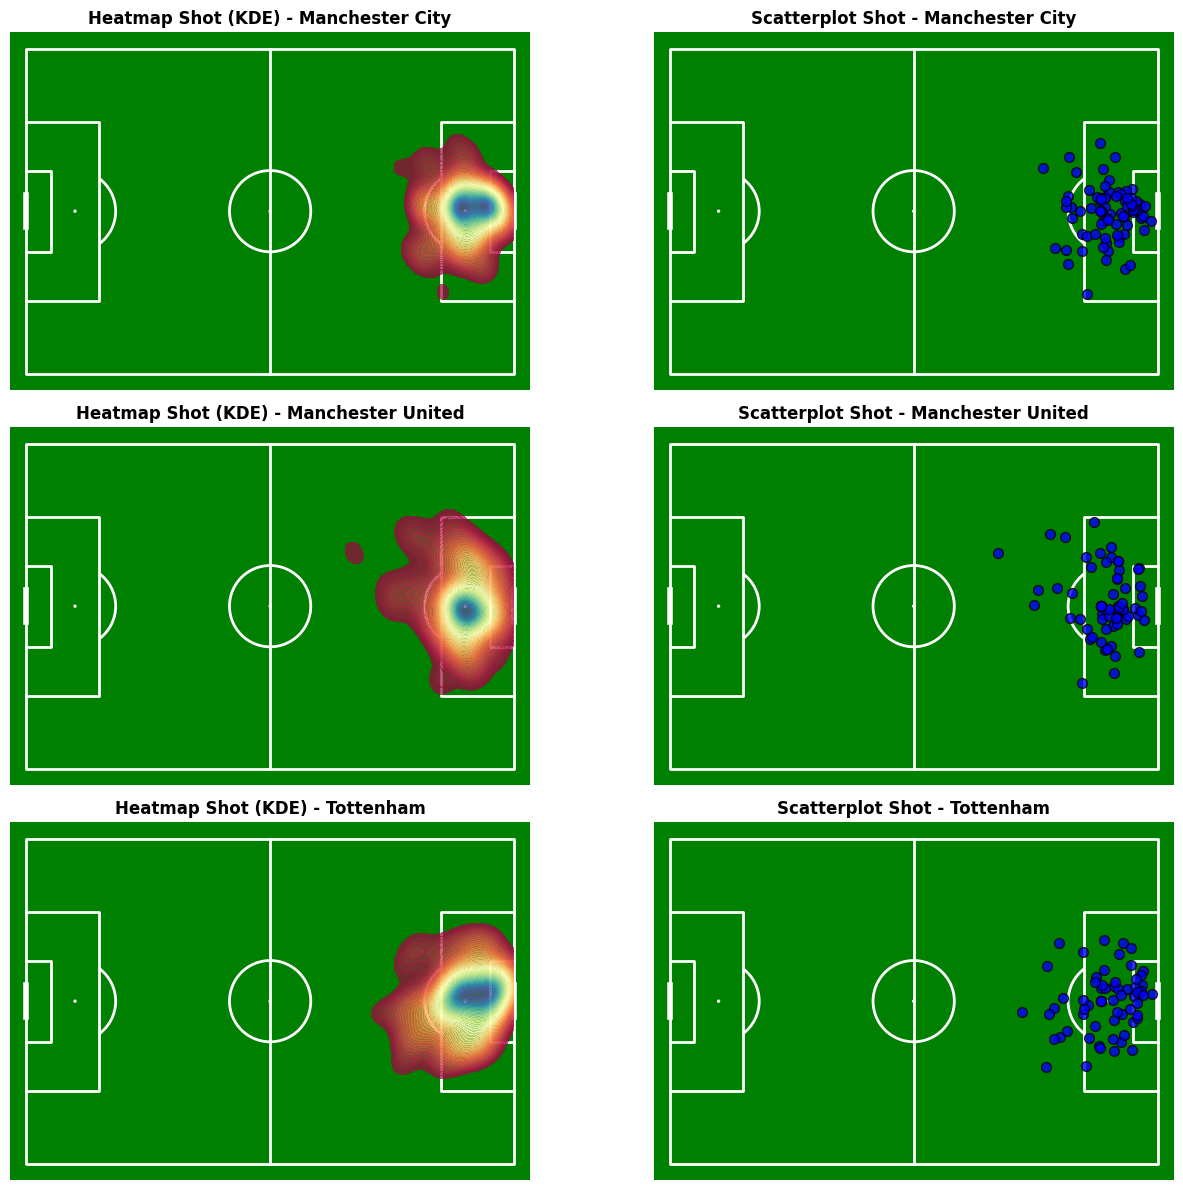

In [ ]:
# Prime 3 squadre per Goal

import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

#  Normalizzazione delle coordinate (da 0-100 a 0-120 per x e 0-100 a 0-80 per y)
def normalize_coordinates(df):
    df["x"] = df["x"] * 1.2  # Porta il range da (0-100) a (0-120)
    df["y"] = df["y"] * 0.8  # Porta il range da (0-100) a (0-80)
    return df

# Filtriamo solo i tiri che hanno portato a goal
goal_shots = sorted_data[(sorted_data["isShot"] == 1) & (sorted_data["isOwnGoal"] != 1) & (sorted_data["isGoal"] == 1)].copy()
goal_shots = normalize_coordinates(goal_shots)

# Troviamo le 3 squadre con più goal
top_teams = goal_shots["team_name"].value_counts().head(3).index  # Usa il nome della squadra

# Creiamo la figura con 3 righe (una per squadra) e 2 colonne (heatmap + scatterplot)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, team_name in enumerate(top_teams):
    team_shots = goal_shots[goal_shots["team_name"] == team_name]

    # Disegna il campo da calcio
    pitch = Pitch(pitch_type='statsbomb', line_color='white', pitch_color='green')

    # HEATMAP a sinistra
    ax_heatmap = axes[i, 0]
    pitch.draw(ax=ax_heatmap)

    # Creiamo la heatmap KDE (densità continua)
    pitch.kdeplot(team_shots["x"], team_shots["y"], ax=ax_heatmap, cmap="Spectral", levels=50, fill=True, alpha=0.7)

    ax_heatmap.set_title(f"Heatmap Shot (KDE) - {team_name}", fontsize=12, fontweight='bold', color='black')

    # SCATTERPLOT a destra
    ax_scatter = axes[i, 1]
    pitch.draw(ax=ax_scatter)
    ax_scatter.scatter(team_shots["x"], team_shots["y"], color="blue", edgecolors="black", s=50, alpha=0.8)
    ax_scatter.set_title(f"Scatterplot Shot - {team_name}", fontsize=12, fontweight='bold', color='black')

# Miglioriamo la disposizione del layout
plt.tight_layout()
plt.show()


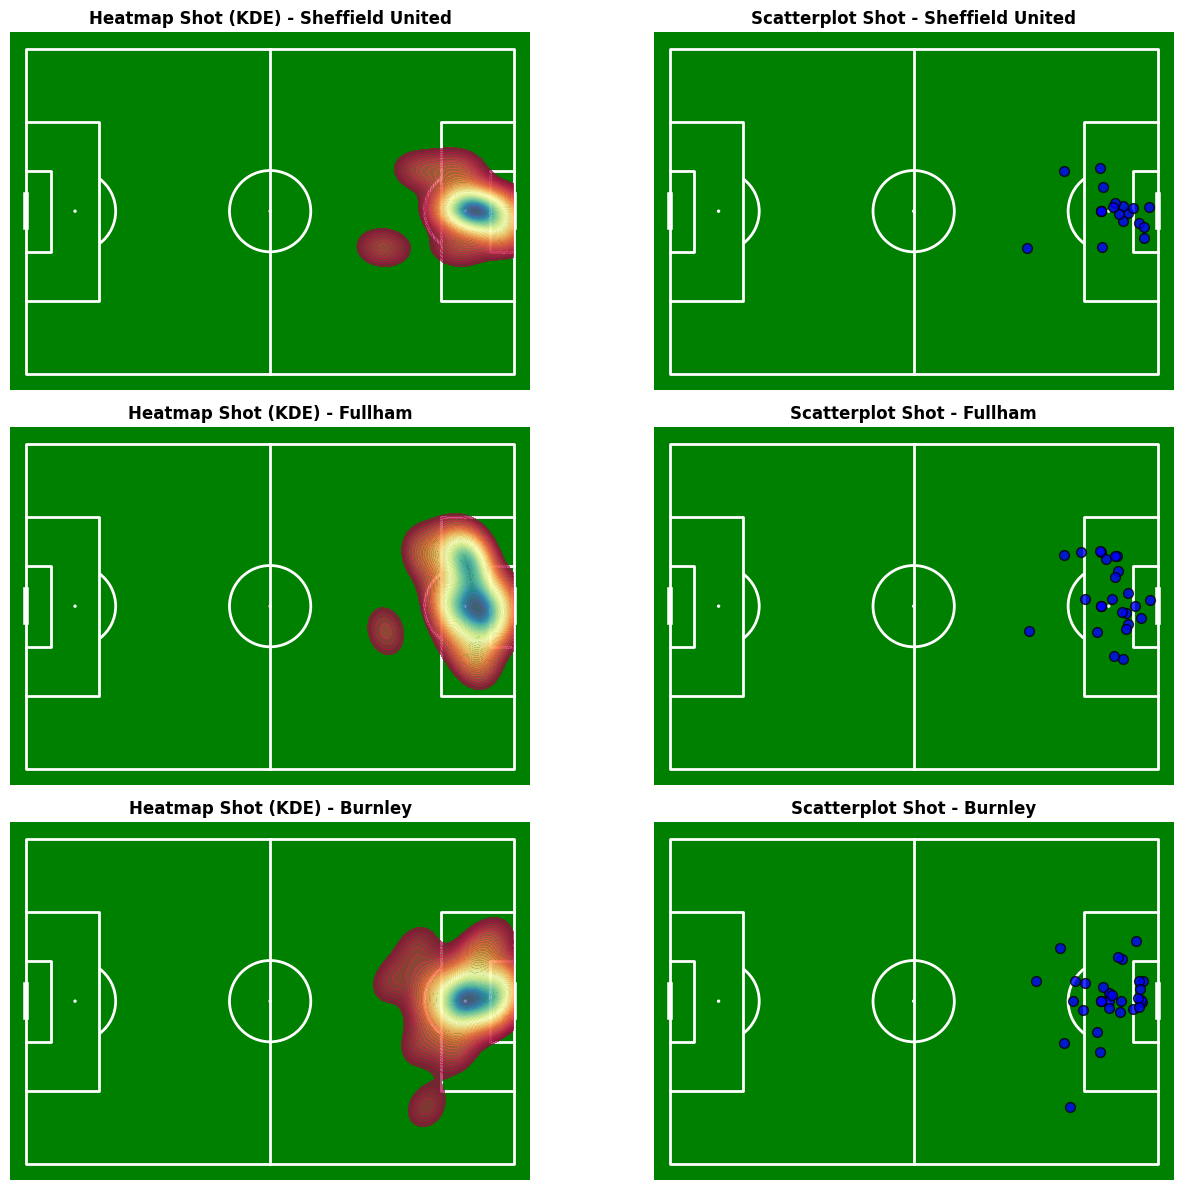

In [ ]:
# Ultime 3 squadre per Goal

import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

#  Normalizzazione delle coordinate (da 0-100 a 0-120 per x e 0-100 a 0-80 per y)
def normalize_coordinates(df):
    df["x"] = df["x"] * 1.2  # Porta il range da (0-100) a (0-120)
    df["y"] = df["y"] * 0.8  # Porta il range da (0-100) a (0-80)
    return df

# Filtriamo solo i tiri che hanno portato a goal
goal_shots = sorted_data[(sorted_data["isShot"] == 1) & (sorted_data["isOwnGoal"] != 1) & (sorted_data["isGoal"] == 1)].copy()
goal_shots = normalize_coordinates(goal_shots)

# Troviamo le 3 squadre con più goal
top_teams = goal_shots["team_name"].value_counts().sort_values(ascending=True).head(3).index  # Usa il nome della squadra

# Creiamo la figura con 3 righe (una per squadra) e 2 colonne (heatmap + scatterplot)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, team_name in enumerate(top_teams):
    team_shots = goal_shots[goal_shots["team_name"] == team_name]

    # Disegna il campo da calcio
    pitch = Pitch(pitch_type='statsbomb', line_color='white', pitch_color='green')

    # HEATMAP a sinistra
    ax_heatmap = axes[i, 0]
    pitch.draw(ax=ax_heatmap)

    # Creiamo la heatmap KDE (densità continua)
    pitch.kdeplot(team_shots["x"], team_shots["y"], ax=ax_heatmap, cmap="Spectral", levels=50, fill=True, alpha=0.7)

    ax_heatmap.set_title(f"Heatmap Shot (KDE) - {team_name}", fontsize=12, fontweight='bold', color='black')

    # SCATTERPLOT a destra
    ax_scatter = axes[i, 1]
    pitch.draw(ax=ax_scatter)
    ax_scatter.scatter(team_shots["x"], team_shots["y"], color="blue", edgecolors="black", s=50, alpha=0.8)
    ax_scatter.set_title(f"Scatterplot Shot - {team_name}", fontsize=12, fontweight='bold', color='black')

# Miglioriamo la disposizione del layout
plt.tight_layout()
plt.show()


**Analisi Goal da calcio d'angolo**

In [ ]:
sorted_goal= sorted_data[(sorted_data["isOwnGoal"] != 1) & (sorted_data["isGoal"] == 1)]

In [ ]:
import ast

def is_from_corner(qualifiers):
    try:
        qualifiers_list = ast.literal_eval(qualifiers)  # Converti la stringa in lista di dizionari
        return any(q.get("type", {}).get("displayName") == "FromCorner" for q in qualifiers_list)
    except (ValueError, SyntaxError):
        return False  # Se la conversione fallisce, restituisci False

In [ ]:
# Applica la funzione ai qualifiers
sorted_goal["isFromCorner"] = sorted_goal["qualifiers"].apply(is_from_corner)

# Filtra solo i gol derivanti da calcio d'angolo
corner_goals = sorted_goal[sorted_goal["isFromCorner"]]

# Mostriamo i primi risultati
corner_goals[["match_id", "team_name", "name", "minute", "isFromCorner"]]

<ipython-input-39-d38877047005>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_goal["isFromCorner"] = sorted_goal["qualifiers"].apply(is_from_corner)


,match_id,team_name,name,minute,isFromCorner
5588,MATCH_1,Arsenal,Gabriel Magalhães,48,True
6687,MATCH_3,Liverpool,Virgil van Dijk,19,True
14408,MATCH_7,Wolves,Romain Saïss,5,True
13817,MATCH_8,Chelsea,Kurt Zouma,65,True
21955,MATCH_9,Everton,Dominic Calvert-Lewin,65,True
...,...,...,...,...,...
560327,MATCH_369,Liverpool,Alex Oxlade-Chamberlain,87,True
596977,MATCH_371,Leeds,Rodrigo,16,True
600358,MATCH_374,Liverpool,Sadio Mané,35,True
598857,MATCH_373,Tottenham,Harry Kane,40,True


In [ ]:
# Conta il numero totale di gol da calcio d'angolo
total_corner_goals = len(corner_goals)
print(f"Numero totale di gol da calcio d'angolo: {total_corner_goals}")

Numero totale di gol da calcio d'angolo: 125


In [ ]:
# Conta il numero di gol da calcio d'angolo per squadra
corner_goals_by_team = corner_goals["team_name"].value_counts()
print("\nNumero di gol da calcio d'angolo per squadra:")
print(corner_goals_by_team)


Numero di gol da calcio d'angolo per squadra:
team_name
Everton                 10
Liverpool               10
Chelsea                  9
Manchester City          9
West Ham                 9
Leeds                    8
Wolves                   7
Newcastle                7
Burnley                  6
Southampton              6
Aston Villa              6
Tottenham                6
Brighton                 5
Leicester                5
Manchester United        5
West Bromwich Albion     5
Sheffield United         4
Fullham                  3
Arsenal                  3
Crystal Palace           2
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def normalize_coordinates(df):
    df["x"] = df["x"] * 1.2  # Porta il range da (0-100) a (0-120)
    df["y"] = df["y"] * 0.8  # Porta il range da (0-100) a (0-80)
    return df

# Filtriamo solo i tiri che hanno portato al goal
goal_corner = corner_goals[((corner_goals["isGoal"] == 1) & (corner_goals["isOwnGoal"] != 1) & (corner_goals["isFromCorner"]==True))]
goal_corner = normalize_coordinates(goal_corner)

# Troviamo le 3 squadre con più goal
top_teams = goal_corner["team_name"].value_counts().head(3).index

# Creiamo la figura con 3 righe (una per squadra) e 2 colonne (heatmap + scatterplot)
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

for i, team_name in enumerate(top_teams):
    team_shots = goal_corner[goal_corner["team_name"] == team_name]

    # Disegna il campo da calcio
    pitch = Pitch(pitch_type='statsbomb', line_color='white', pitch_color='green')

    # HEATMAP a sinistra
    ax_heatmap = axes[i, 0]
    pitch.draw(ax=ax_heatmap)

    # Creiamo la heatmap KDE (densità continua)
    pitch.kdeplot(team_shots["x"], team_shots["y"], ax=ax_heatmap, cmap="Spectral", levels=50, fill=True, alpha=0.7)

    ax_heatmap.set_title(f"Heatmap Goal from Corner (KDE) - {team_name}", fontsize=12, fontweight='bold', color='black')

    # SCATTERPLOT a destra
    ax_scatter = axes[i, 1]
    pitch.draw(ax=ax_scatter)
    ax_scatter.scatter(team_shots["x"], team_shots["y"], color="blue", edgecolors="black", s=50, alpha=0.8)
    ax_scatter.set_title(f"Scatterplot Goal from Corner - {team_name}", fontsize=12, fontweight='bold', color='black')

# Miglioriamo la disposizione del layout
plt.tight_layout()
plt.show()

NameError: name 'corner_goals' is not defined

**Analisi Possesso Palla**

In [ ]:
#Funzione per calcolare il tempo del possesso palla

def calculate_time_possession(df):
    # Sort by time (minute, second)
    df = df.sort_values(by=["expandedMinute", "second"])

    # Calculate time difference between consecutive events
    df["time_diff"] = df["second"].diff().fillna(0)

    # quando il minuto cambia aggiunge 60 secondi se è ancora in possesso
    df.loc[df["expandedMinute"].diff() == 1, "time_diff"] += 60

    # Group by team and sum possession time
    team_time = df.groupby("team_name")["time_diff"].sum()

    # Normalize to get possession percentage
    total_time = team_time.sum()
    possession = (team_time / total_time) * 100

    return possession

In [ ]:
#Possesso palla per partita diviso per squadre
match_ball_possession = sorted_data.groupby(by="match_id").apply(calculate_time_possession).reset_index()
match_field_coverage = sorted_data.groupby(by=["match_id","team_name"])[["x","y"]].mean().reset_index()

<ipython-input-44-8b5c04e02017>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  match_ball_possession = sorted_data.groupby(by="match_id").apply(calculate_time_possession).reset_index()


In [ ]:
#Merge dei due Dataframe creati
match_stats = pd.merge(match_ball_possession, match_field_coverage, on='team_name', how='inner')
match_stats = match_stats.loc[:, ~match_stats.columns.duplicated()]

In [ ]:
# Media Possesso Palla per tutte le squadre (per tutta la stagione)
team_avg_possesion = match_stats.groupby(by="team_name")["time_diff"].mean().reset_index()
team_avg_dominance = match_stats.groupby(by="team_name")["x"].mean().reset_index()

In [ ]:
#Merge dei due Dataframe
team_avg_stats = pd.merge(team_avg_possesion,team_avg_dominance, on="team_name",how="inner")

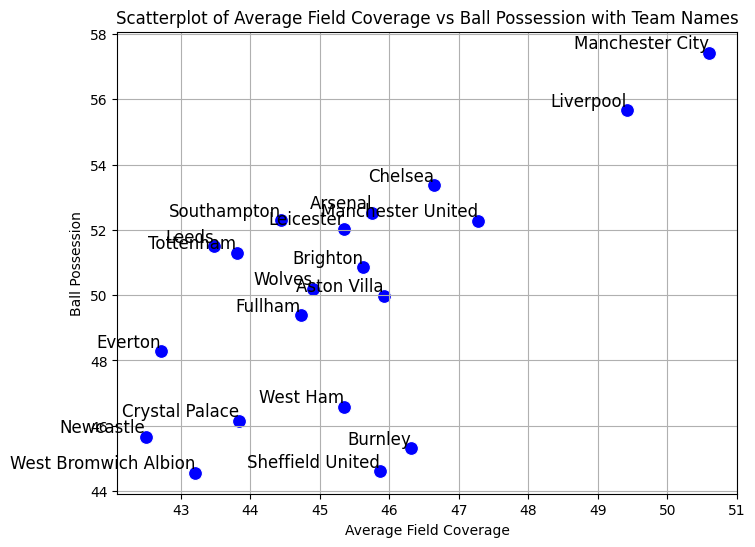

In [ ]:
#Grafico per possesso palla e dominio territoriale

plt.figure(figsize=(8,6))
sn.scatterplot(data=team_avg_stats, x="x", y="time_diff", s=100, color="blue")

# Annotate each point with the teamId
for i, row in team_avg_stats.iterrows():
    plt.text(row["x"], row["time_diff"], str(row["team_name"]), fontsize=12, ha='right', va='bottom')

# Labels and title
plt.xlabel("Average Field Coverage")
plt.ylabel("Ball Possession")
plt.title("Scatterplot of Average Field Coverage vs Ball Possession with Team Names")
plt.grid(True)

# Show plot
plt.show()

**Analisi Passaggi**

In [ ]:
# Filtriamo solo gli eventi relativi ai passaggi
df_passes = sorted_data[sorted_data["type_displayName"] == "Pass"]

# Statistiche sui passaggi per squadra
passes_by_team = df_passes.groupby("team_name").agg(
    total_passes=("name", "count"),
    mean_x=('x', "mean"),
    mean_y=("y", "mean")
).reset_index()

# Ordiniamo per numero totale di passaggi
passes_by_team = passes_by_team.sort_values(by="total_passes", ascending=False)

print("Statistiche sui passaggi per squadra:")
(passes_by_team.head(5))


Statistiche sui passaggi per squadra:


,team_name,total_passes,mean_x,mean_y
11,Manchester City,27110,52.007204,51.396400
10,Liverpool,26161,50.911876,49.967643
4,Chelsea,25720,48.222387,48.942928
12,Manchester United,22551,49.823919,51.260844
0,Arsenal,21741,48.034975,51.140743


In [ ]:
# Statistiche sui passaggi per giocatore
passes_by_player = df_passes.groupby(["team_name", "name"]).agg(
    total_passes=("name", "count"),
    mean_x=("x", "mean"),
    mean_y=("y", "mean")
).reset_index()

# Ordiniamo per numero totale di passaggi
passes_by_player = passes_by_player.sort_values(by="total_passes", ascending=False)

print("Statistiche sui passaggi per giocatore:")
(passes_by_player.head(5))


Statistiche sui passaggi per giocatore:


,team_name,name,total_passes,mean_x,mean_y
266,Liverpool,Andrew Robertson,3295,56.668255,86.391442
288,Liverpool,Trent Alexander-Arnold,3004,55.953129,15.734820
310,Manchester City,Rodri,2800,50.615643,51.214964
441,Tottenham,Pierre-Emile Højbjerg,2778,47.060979,53.888445
225,Leeds,Luke Ayling,2762,43.354562,18.436495


In [ ]:
def get_pass_info(match_df):
    '''
    input : df di una partita
    output: df con numero di passaggi effettuti, passaggi riusciti, precisione passaggi (%)  , lunghezza passaggi
    '''
    ## evita confusione con gli indici
    match_df = match_df.reset_index()
    passes_info_df = pd.DataFrame({})
    ## subset eventi passaggio nella partia
    passes_df = match_df.loc[match_df["type_displayName"]=="Pass", : ]

    ## calcoala distanza euclidea per ottenere la distanza del passaggio

    passes_df["pass_length"]           = np.sqrt((match_df["endX"] - match_df["x"])**2 + (match_df["endY"] - match_df["y"])**2)

    ## raggruppamento per squadra: conta eventi passaggio per ogni squadra
    passes_info_df["total_passes"]          = passes_df.groupby(by="team_name").count().iloc[:,0]
    ##  eventi passaggio che sono contrssegnati come successfull
    passes_info_df["completed_passes"]      = passes_df[passes_df["outcomeType_displayName"] == "Successful"].groupby(by="team_name").count().reset_index().iloc[:,1].values
    passes_info_df["pass_accuracy"]         = round(passes_info_df["completed_passes"] / passes_info_df["total_passes"],2)
    ## media della lunghezza dei passaggi per le due squadre
    passes_info_df["average_pass_length"]   = passes_df.groupby(by="team_name")["pass_length"].mean().values
    return passes_info_df.reset_index()

## ottenimento delle statistiche per ogni partita
pass_stats_season = sorted_data.groupby(by="match_id").apply(get_pass_info).reset_index()

<ipython-input-53-2007dbece43a>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pass_stats_season = sorted_data.groupby(by="match_id").apply(get_pass_info).reset_index()


In [ ]:
## raggruppamento per tutta la stagione
pass_stats_season_avg = pass_stats_season.groupby(by = "team_name")[["total_passes","completed_passes","pass_accuracy","average_pass_length"]].mean().reset_index()
pass_stats_season_avg.head(5)

,team_name,total_passes,completed_passes,pass_accuracy,average_pass_length
0,Arsenal,572.131579,474.657895,0.821316,21.370687
1,Aston Villa,445.394737,340.473684,0.753684,23.058974
2,Brighton,521.552632,415.052632,0.787632,22.558998
3,Burnley,407.421053,284.868421,0.693158,23.531303
4,Chelsea,676.842105,578.131579,0.851316,20.364505


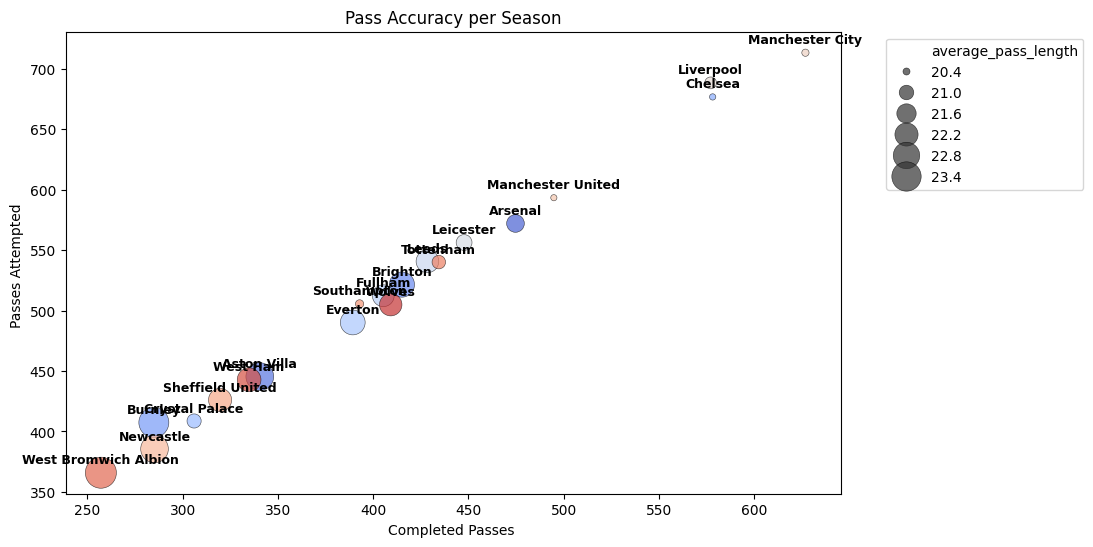

In [ ]:
## bubble chart: 1 dimensione passaggi effettuati, un'altra (passaggi completati), dimensione bubbles sono la lunghezza media dei passaggi per partita
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sn.scatterplot(
    data=pass_stats_season_avg,
    x="completed_passes",
    y="total_passes",
    size="average_pass_length",
    hue="team_name",
    sizes=(20, 500),
    palette="coolwarm",
    edgecolor="black",
    alpha=0.7,
    # legend=False
)
handles, labels = ax.get_legend_handles_labels()

new_handles = handles[len(labels)-7  : ]
new_labels = labels[len(labels)-7  : ]
for i in range(len(pass_stats_season_avg)):
   plt.text(
        pass_stats_season_avg["completed_passes"][i],
        pass_stats_season_avg["total_passes"][i] +5,
        pass_stats_season_avg["team_name"][i],
        fontsize=9, ha='center', va='bottom', weight='bold'
    )
plt.title("Pass Accuracy per Season")
ax.legend(new_handles, new_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("Completed Passes ")
ax.set_ylabel("Passes Attempted ")

plt.show()

In [ ]:
def get_passes_before_shots(match_df):
    match_df = match_df.reset_index()
    passes_before_shots = 0
    _teams =  pd.unique(match_df["team_name"])
    avg_pass_before_shots = {_teams[0] : [],
                             _teams[1] : [] }

    for idx, row in match_df.iterrows():
        if pd.notna(row["isShot"]):  # Found a shot event
            print(f"I have found a shot of team: {row['team_name']}")
            for i in range(idx-1, -1, -1):  # Iterate backward from the shot
                if match_df.iloc[i]["team_name"] == row["team_name"]:  # Check same team
                    if match_df.iloc[i]["type_displayName"] == "Pass":  # Ensure it's a pass
                        passes_before_shots += 1
                    print(f"Considering row: {match_df.iloc[i][['team_name', 'expandedMinute', 'type_displayName']]}")
                else:
                    break  # Stop if the team changes
            print(f"Passes before shot: {passes_before_shots}")
            # avg_pass_before_shots.append(passes_before_shots)  # Append result for this shot

            avg_pass_before_shots[row["team_name"]].append(passes_before_shots)
            passes_before_shots = 0  # Reset for next shot

    return avg_pass_before_shots  # Return 0 if no passes were found before shots
passess_before_shots = sorted_data.groupby(by=["match_id"]).apply(get_passes_before_shots)

Output streaming troncato alle ultime 5000 righe.
expandedMinute                  27
type_displayName              Pass
Name: 515, dtype: object
Passes before shot: 1
I have found a shot of team: Burnley
Considering row: team_name           Burnley
expandedMinute           34
type_displayName       Pass
Name: 627, dtype: object
Considering row: team_name           Burnley
expandedMinute           34
type_displayName       Pass
Name: 626, dtype: object
Considering row: team_name                Burnley
expandedMinute                34
type_displayName    BallRecovery
Name: 625, dtype: object
Considering row: team_name           Burnley
expandedMinute           34
type_displayName       Pass
Name: 624, dtype: object
Passes before shot: 3
I have found a shot of team: Crystal Palace
Passes before shot: 0
I have found a shot of team: Crystal Palace
Considering row: team_name           Crystal Palace
expandedMinute                  36
type_displayName              Pass
Name: 668, dtype: objec

<ipython-input-56-efbc7c7b1aed>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  passess_before_shots = sorted_data.groupby(by=["match_id"]).apply(get_passes_before_shots)


<ipython-input-57-c61ad33b9d98>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  avg_pass_shots_df = df_passes_before_shots.applymap(lambda x: np.mean(x))


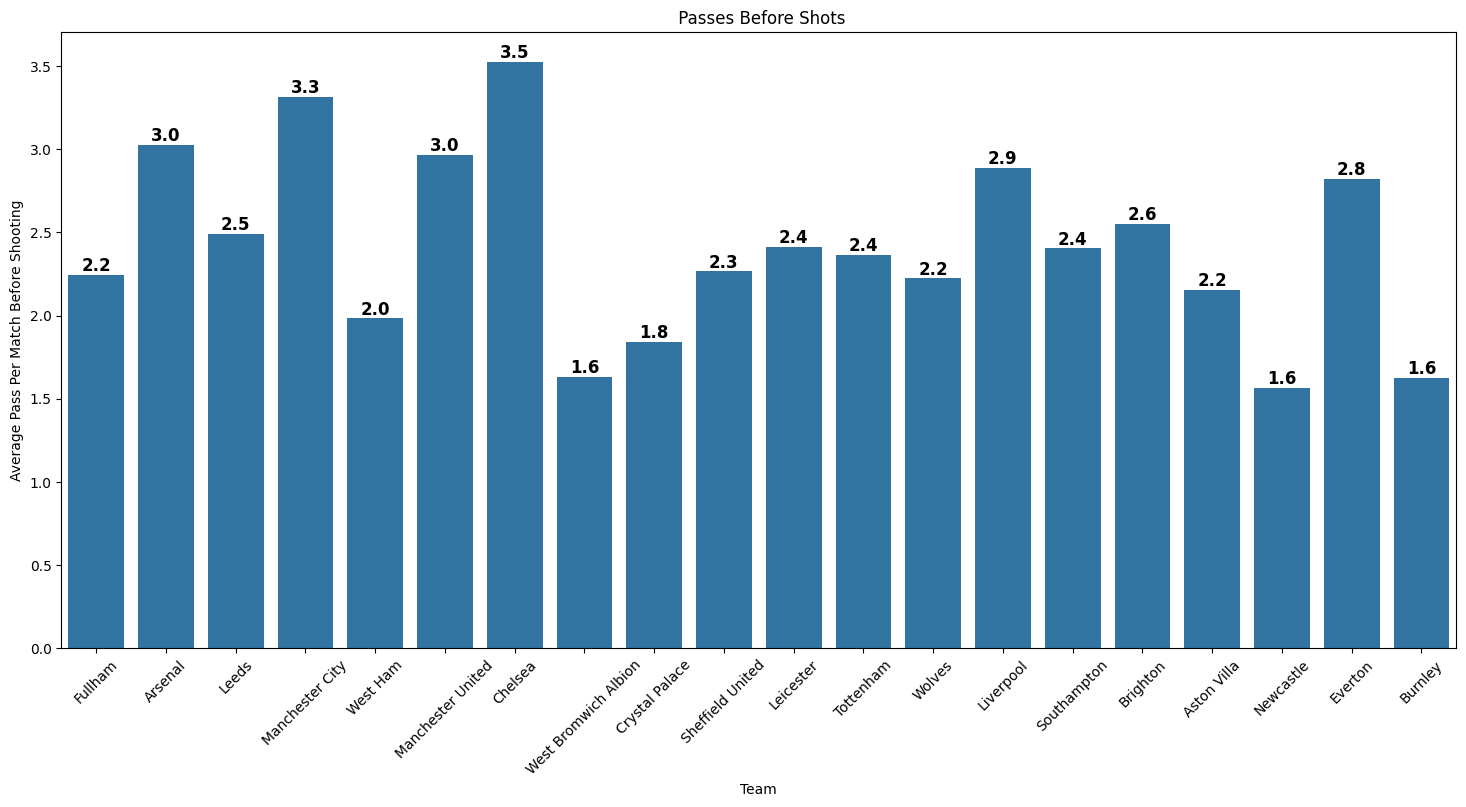

In [ ]:
df_passes_before_shots= pd.DataFrame.from_dict(dict(passess_before_shots), orient="index")
plt.figure(figsize=(18, 8))

avg_pass_shots_df = df_passes_before_shots.applymap(lambda x: np.mean(x))
avg_pass_per_match = avg_pass_shots_df.apply(lambda x:np.mean(x),axis = 0 )
ax = sn.barplot(x = avg_pass_per_match.index, y = avg_pass_per_match)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)

plt.xlabel("Team")
plt.ylabel("Average Pass Per Match Before Shooting")
plt.title(" Passes Before Shots")
plt.show()

<Figure size 1400x600 with 0 Axes>

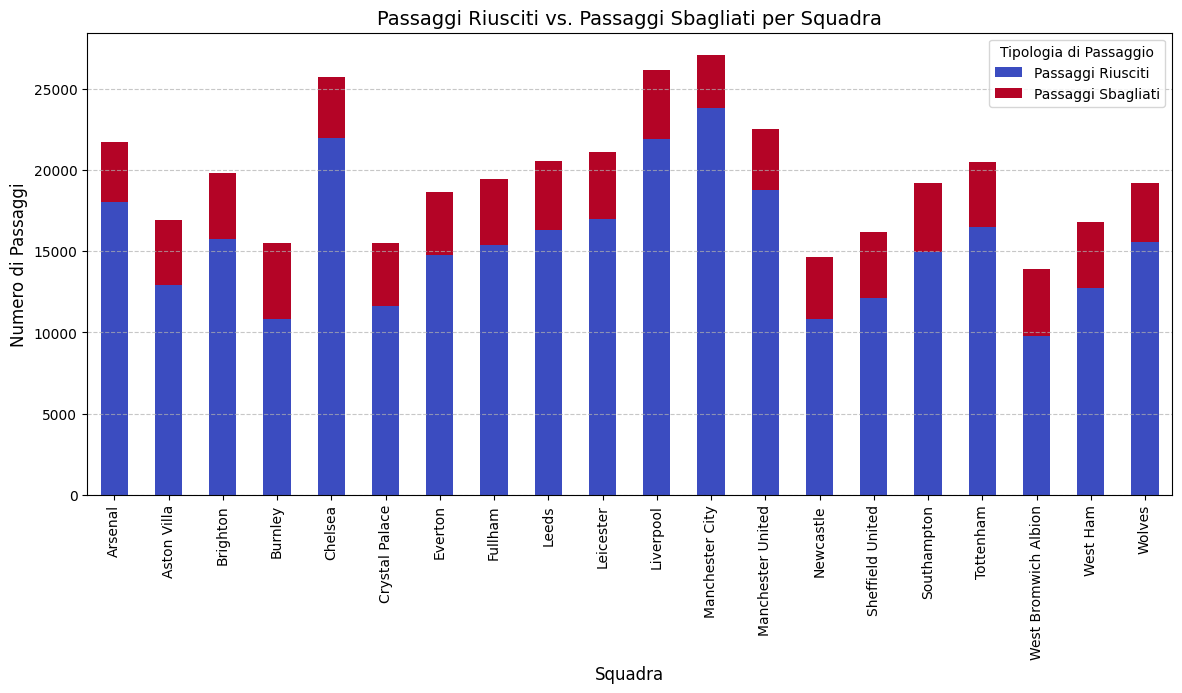

In [ ]:
# Creiamo una tabella con il conteggio dei passaggi riusciti e sbagliati per squadra
pass_stats = df_passes.groupby(["team_name", "outcomeType_displayName"]).size().unstack(fill_value=0)

# Rinominiamo le colonne per chiarezza
pass_stats = pass_stats.rename(columns={"Successful": "Passaggi Riusciti", "Unsuccessful": "Passaggi Sbagliati"})

pass_stats = pass_stats.reset_index()

# Creazione del barplot
plt.figure(figsize=(14, 6))
pass_stats.plot(x="team_name", kind="bar", stacked=True, figsize=(14,6), colormap="coolwarm")

# Titolo e etichette
plt.title("Passaggi Riusciti vs. Passaggi Sbagliati per Squadra", fontsize=14)
plt.xlabel("Squadra", fontsize=12)
plt.ylabel("Numero di Passaggi", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title="Tipologia di Passaggio")
plt.grid(axis="y", linestyle="--", alpha=0.7)


plt.show()


In [ ]:
# Confronto passaggi tra Manchester City e Manchester United
teams_of_interest = ["Manchester City", "Manchester United"]

# Filtra solo le righe che contengono le squadre di Manchester
df_manchester = sorted_data[sorted_data["team_name"].isin(teams_of_interest)]

# Conta quante squadre sono presenti per ogni match_id
match_counts = df_manchester.groupby("match_id")["team_name"].nunique()

# Seleziona i match_id in cui entrambe le squadre hanno giocato
derby_matches = match_counts[match_counts == 2].index.tolist()

print("Le giornate in cui si sono scontrati Manchester City e Manchester United sono:")
print(derby_matches)


Le giornate in cui si sono scontrati Manchester City e Manchester United sono:
['MATCH_111', 'MATCH_272']


In [ ]:
from mplsoccer import Pitch

def plot_heatmap(df:pd.DataFrame, condition:str, ax,team_level:bool=False):
    subset = "team_name" if team_level else "name"
    # print("subset",subset)
    player_data = df[df[subset] == condition]
    # print("len pl data", len(player_data))
    # Create pitch on the given axis
    pitch = Pitch(line_color='white', pitch_color='#02540b')
    pitch.draw(ax=ax)

    # nel caso si è inserito team level x e y faranno riferimento alle coordinate di tutti i tocchi effetati dal team
    pitch.kdeplot(
        x=player_data['x'],
        y=player_data['y'],
        fill=True,
        shade_lowest=False,
        alpha=0.5,
        n_levels=10,
        cmap='plasma',
        ax=ax
    )

    # Title for subplot
    ax.set_title(f"{condition} Heatmap", fontsize=14, color='black')

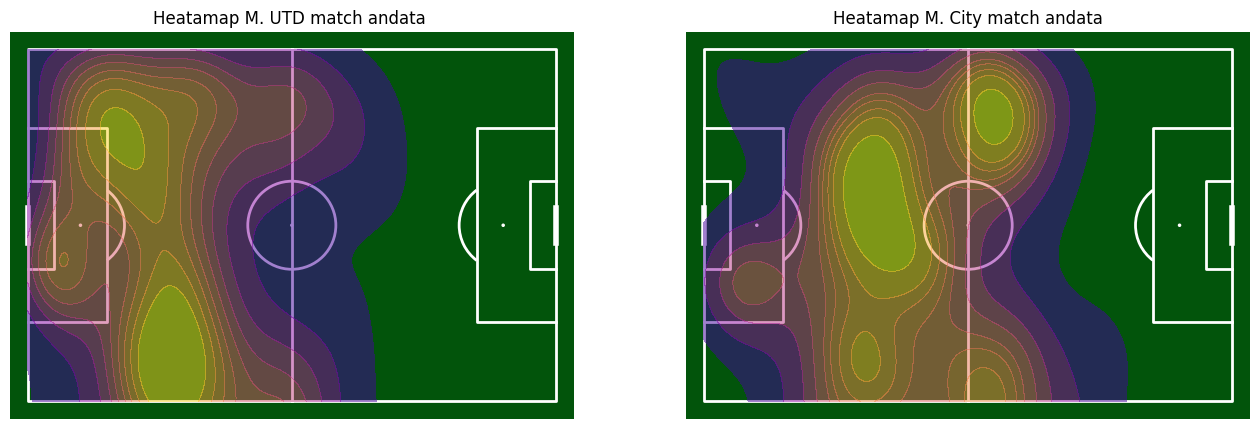

In [ ]:
#Match d'andata

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_heatmap(sorted_data[sorted_data["match_id"] == "MATCH_111"], "Manchester United", axes[0], team_level=True)
plot_heatmap(sorted_data[sorted_data["match_id"] == "MATCH_111"], "Manchester City", axes[1], team_level=True)
axes[0].set_title("Heatamap M. UTD match andata ")
axes[1].set_title("Heatamap M. City match andata")

plt.show()

In [ ]:
import matplotlib.patches as patches
from matplotlib.lines import Line2D

#Funzione per graficare i passaggi riusciti/sbagliati per una partita per singolo giocatore

def plot_passes_with_pitch_elements(df,match_id,player_name):
    # Filtra gli eventi di passaggio con coordinate valide
    pass_df = df[(df['type_displayName'] == 'Pass') &
                 (df.name == player_name) &
                 (df.match_id == match_id) &
                 (df['endX'].notna()) &
                 (df['endY'].notna())]

    # Crea figura e assi
    fig, ax = plt.subplots(figsize=(10, 7))

    # Disegna il campo
    pitch_background = patches.Rectangle(
        (0, 0), 100, 100,
        linewidth=2, edgecolor='white', facecolor='#02540b', zorder=0
    )
    ax.add_patch(pitch_background)

    # linea centrale e centrocampo
    # Linea centrale
    ax.plot([50, 50], [0, 100], color='white', lw=2)
    # Centrocampo(circonferenza centrale)
    center_circle = patches.Circle((50, 50), radius=10, fill=False, edgecolor='white', lw=2)
    ax.add_patch(center_circle)
    # Punto centrale
    ax.scatter(50, 50, color='white', s=50, zorder=5)

    #aree di rigore
    # Area di rigore sinistra
    left_penalty = patches.Rectangle((0, 30), 16.5, 40, fill=False, edgecolor='white', lw=2)
    ax.add_patch(left_penalty)
    # Area di rigore destra
    right_penalty = patches.Rectangle((100 - 16.5, 30), 16.5, 40, fill=False, edgecolor='white', lw=2)
    ax.add_patch(right_penalty)

    # Inverte l'asse y per avere l'origine in basso a sinistra
    ax.invert_yaxis()

    # Ciclo per disegnare ogni passaggio
    for idx, row in pass_df.iterrows():
        start_x, start_y = row['x'], row['y']
        end_x, end_y = row['endX'], row['endY']
        dx = end_x - start_x
        dy = end_y - start_y

        # Colore della linea: giallo se il passaggio è riuscito, rosso altrimenti
        if row['outcomeType_displayName'] != 'Unsuccessful':
            arrow_color = 'yellow'
        else:
            arrow_color = 'red'

        # Disegna la freccia per il passaggio
        ax.arrow(start_x, start_y, dx, dy,
                 color=arrow_color,
                 head_width=1.5, head_length=1.5,
                 length_includes_head=True, alpha=0.8)

        # Disegna i marker per i punti di inizio e fine
        ax.scatter(start_x, start_y, color='blue', s=100, marker='o', zorder=5)
        ax.scatter(end_x, end_y, color='blue', s=100, marker='o', zorder=5)

    # Imposta i limiti del grafico e rimuove le etichette degli assi
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_xticks([])
    ax.set_yticks([])

    # legenda
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Inizio/Fine', markerfacecolor='blue', markersize=10),
        Line2D([0], [0], color='yellow', lw=2, label='Passaggio riuscito'),
        Line2D([0], [0], color='red', lw=2, label='Passaggio sbagliato')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.title("Passaggi con Centrocampo e Aree di Rigore", fontsize=16)
    plt.show()


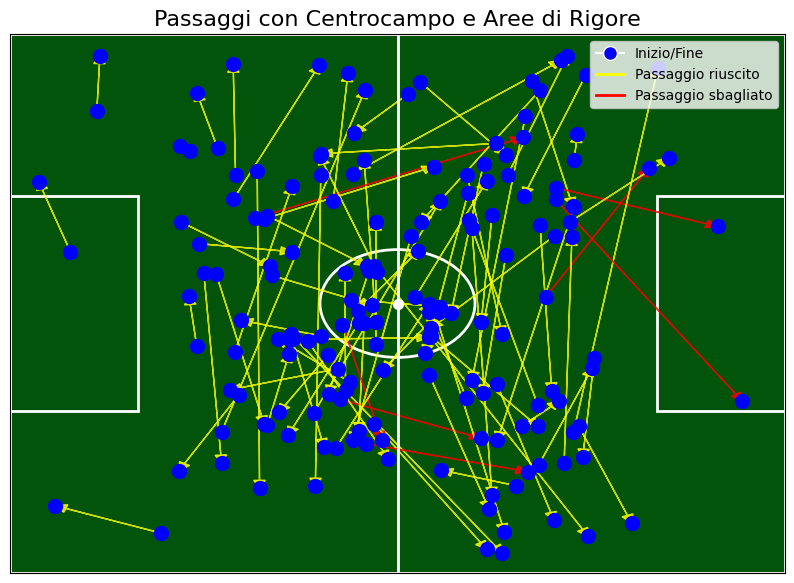

In [ ]:
# Grafico Passaggi Rodri, con match_id = MATCH_111 (recuperato prima)
plot_passes_with_pitch_elements(sorted_data,'MATCH_111','Rodri')

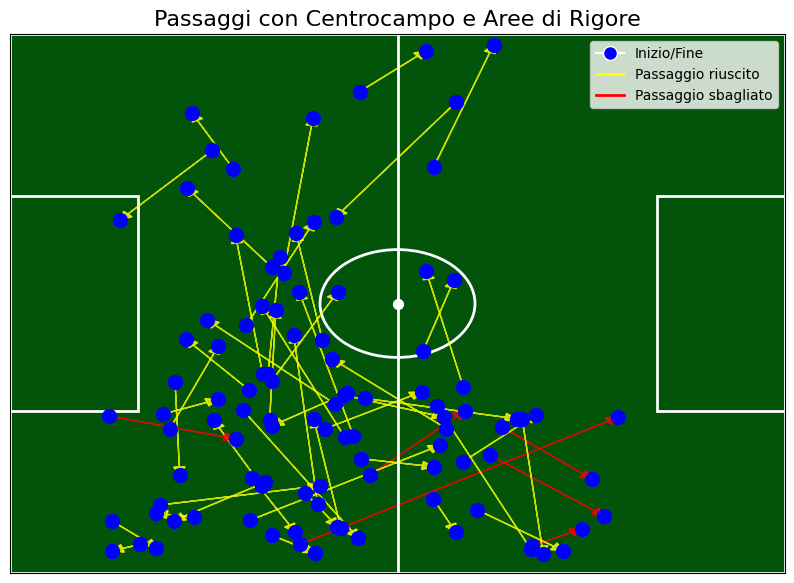

In [ ]:
# Grafico Passaggi Scott McTominay, con match_id = MATCH_111 (recuperato prima)
plot_passes_with_pitch_elements(sorted_data,'MATCH_111','Scott McTominay')

In [ ]:
import json

def get_match_result(match_df):
    score = match_df.groupby(by = ["match_id","team_name","isOwnGoal_bin"])["isGoal_bin"].sum().reset_index()
    score["adjusted_goals"] = score["isOwnGoal_bin"] + score["isGoal_bin"]

    own_goal_teams = score.loc[score["isOwnGoal_bin"] < 0, "team_name"].unique()
    if len(own_goal_teams) > 0:
        for own_goal_team in own_goal_teams:
            score.loc[score["team_name"]!=own_goal_team, "adjusted_goals"] += 1
    return score.groupby(by="team_name")["adjusted_goals"].sum()

def get_match_stats(match_df):
    '''
    input : dataframe patita
    output: tabella righe features e colonne  = squadre

    '''
    match_stats_df = pd.DataFrame()
    ## risultato partita
    match_stats_df.index = pd.unique(match_df["team_name"])
    match_stats_df["Goals"] = match_stats_df.join(get_match_result(match_df))

    ## tiri totali

    ## tiri in porta
    match_stats_df["Total Attempts"] = match_df.groupby(by="team_name")["isShot"].sum()
    # match_stats_df["shots on target"] = match_df.groupby(by=["team_name","outcomeType_displayName"])["isShot"].sum()

    # shots_qualifiers  = get_missed_shots(match_df)
    ##  possesso palla
    ball_possesion = calculate_time_possession(match_df)
    match_stats_df = match_stats_df.join(ball_possesion).rename(columns = {"time_diff" : "Ball Possesion"})

    ## batricentro medio (si considera solo la x del baricentro)
    match_stats_df = match_stats_df.join(match_df.groupby(by="team_name")["x"].mean()).rename(columns = {"x" : "Average Field Coverage"})

    for team in match_stats_df.index:
        # print(match_stats_df.loc[team])
        match_stats_df.loc[team,"Avg Pass Before Shot"] = round(np.mean([ i for  i in passess_before_shots[match_df["match_id"]][0][team] if i != 0 ]),2)

    return match_stats_df.transpose()

get_match_stats(sorted_data[sorted_data["match_id"] == "MATCH_111"])

<ipython-input-65-44f4624aaf2a>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  match_stats_df.loc[team,"Avg Pass Before Shot"] = round(np.mean([ i for  i in passess_before_shots[match_df["match_id"]][0][team] if i != 0 ]),2)
<ipython-input-65-44f4624aaf2a>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  match_stats_df.loc[team,"Avg Pass Before Shot"] = round(np.mean([ i for  i in passess_before_shots[match_df["match_id"]][0][team] if i != 0 ]),2)


,Manchester City,Manchester United
Goals,0,0
Total Attempts,9,11
Ball Possesion,52.194762,47.805238
Average Field Coverage,47.818541,37.770351
Avg Pass Before Shot,2.83,4.62


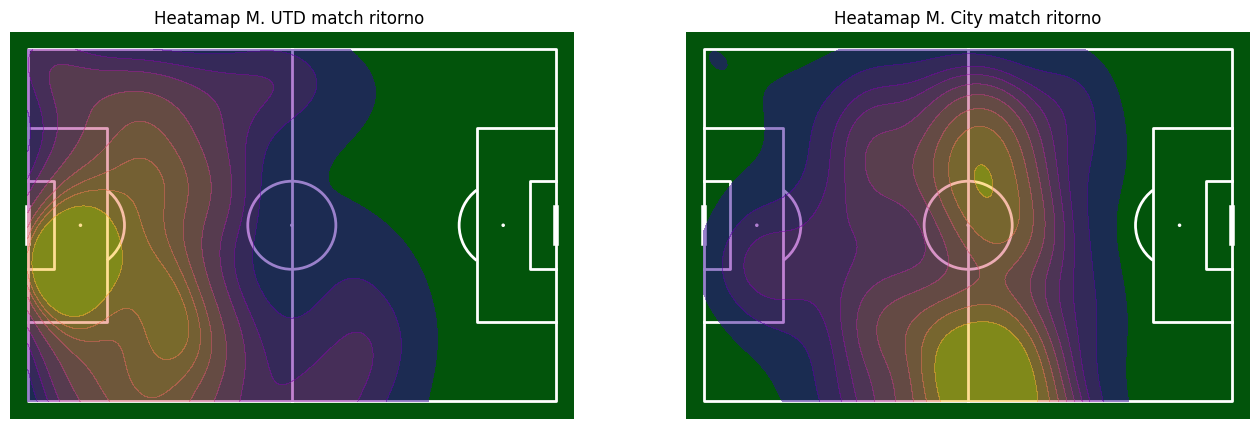

In [ ]:
#Match di ritorno

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_heatmap(sorted_data[sorted_data["match_id"] == "MATCH_272"], "Manchester United", axes[0], team_level=True)
plot_heatmap(sorted_data[sorted_data["match_id"] == "MATCH_272"], "Manchester City", axes[1], team_level=True)
axes[0].set_title("Heatamap M. UTD match ritorno ")
axes[1].set_title("Heatamap M. City match ritorno")

plt.show()

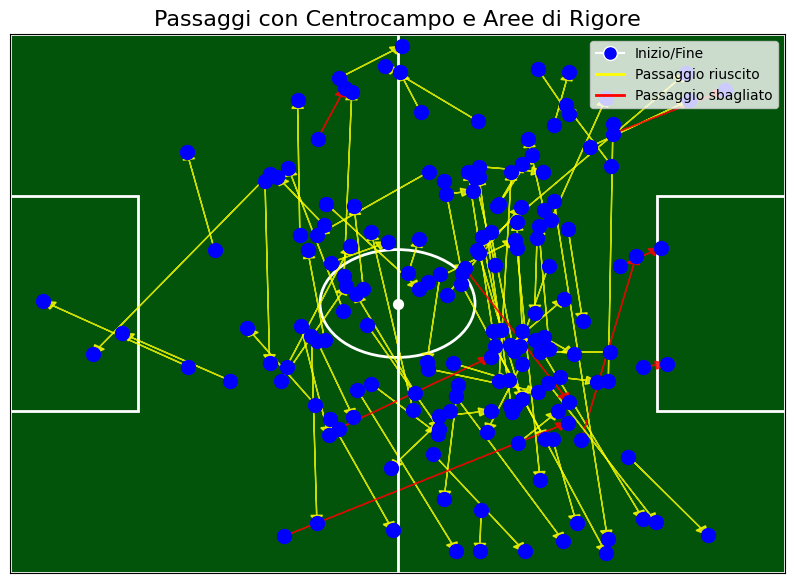

In [ ]:
# Grafico Passaggi Rodri, con match_id = MATCH_272 (ritorno)
plot_passes_with_pitch_elements(sorted_data,'MATCH_272','Rodri')

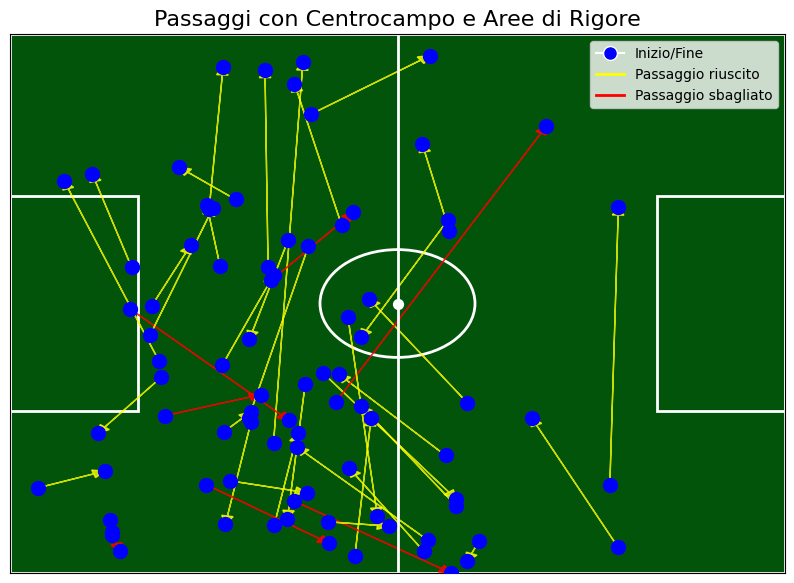

In [ ]:
# Grafico Passaggi Scott McTominay, con match_id = MATCH_272
plot_passes_with_pitch_elements(sorted_data,'MATCH_272','Scott McTominay')

In [ ]:
#Stats match di ritrno
get_match_stats(sorted_data[sorted_data["match_id"] == "MATCH_272"])

<ipython-input-65-44f4624aaf2a>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  match_stats_df.loc[team,"Avg Pass Before Shot"] = round(np.mean([ i for  i in passess_before_shots[match_df["match_id"]][0][team] if i != 0 ]),2)
<ipython-input-65-44f4624aaf2a>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  match_stats_df.loc[team,"Avg Pass Before Shot"] = round(np.mean([ i for  i in passess_before_shots[match_df["match_id"]][0][team] if i != 0 ]),2)


,Manchester United,Manchester City
Goals,2,0
Total Attempts,8,23
Ball Possesion,41.894169,58.105831
Average Field Coverage,35.723547,54.688943
Avg Pass Before Shot,2.0,4.47


## Features Engineering, creazione classe 'result'##

In [ ]:
# Creiamo un nuovo dataframe raggruppando per match_id, team_name e type_displayName(eventi) e ne facciamo il count

df_events_counts = sorted_data.groupby(['match_id', 'team_name', 'type_displayName']).size().reset_index(name='count')
df_events_counts.head(5)

,match_id,team_name,type_displayName,count
0,MATCH_1,Arsenal,Aerial,13
1,MATCH_1,Arsenal,BallRecovery,42
2,MATCH_1,Arsenal,BallTouch,16
3,MATCH_1,Arsenal,BlockedPass,4
4,MATCH_1,Arsenal,Card,2


In [ ]:
#Creaiamo una tabella pivot raggruppando per match_id e team_name,
#ogni evento diventa una colonna con i count corrispondenti

df_pivot = df_events_counts.pivot_table(index=['match_id', 'team_name'],
                                         columns='type_displayName',
                                         values='count',
                                         fill_value=0).reset_index()

df_pivot.columns.name = None  # Rimuove il nome delle colonne proveniente dalla pivot
(df_pivot.head(5))

,match_id,team_name,Aerial,BallRecovery,BallTouch,BlockedPass,Card,Challenge,ChanceMissed,Claim,...,Save,SavedShot,ShieldBallOpp,ShotOnPost,Smother,Start,SubstitutionOff,SubstitutionOn,Tackle,TakeOn
0,MATCH_1,Arsenal,13.0,42.0,16.0,4.0,2.0,6.0,0.0,0.0,...,3.0,6.0,0.0,1.0,0.0,2.0,3.0,3.0,12.0,10.0
1,MATCH_1,Fullham,13.0,46.0,28.0,5.0,2.0,6.0,0.0,0.0,...,6.0,3.0,0.0,0.0,0.0,2.0,3.0,3.0,11.0,12.0
2,MATCH_10,Fullham,38.0,70.0,48.0,15.0,2.0,12.0,0.0,0.0,...,4.0,6.0,0.0,1.0,0.0,2.0,3.0,3.0,18.0,31.0
3,MATCH_10,Leeds,38.0,67.0,39.0,4.0,1.0,20.0,0.0,0.0,...,6.0,4.0,0.0,0.0,1.0,2.0,2.0,2.0,22.0,18.0
4,MATCH_100,Fullham,17.0,48.0,34.0,8.0,0.0,12.0,0.0,0.0,...,6.0,2.0,2.0,0.0,0.0,2.0,3.0,3.0,17.0,24.0


In [ ]:
# Creiamo una funzione che in base al numero dei Goal delle squadre per match_id
# crea le classi Vittoria, Sconfitta, Pareggio.

def assign_result(sub_df):
    # Se i goal sono uguali, entrambe hanno pareggio
    if sub_df['Goal'].nunique() == 1:
        sub_df['result'] = 'Pareggio'
    else:
        max_goal = sub_df['Goal'].max()
        # La squadra che ha segnato il maggior numero di goal ottiene "Vittoria",
        # l'altra "Sconfitta"
        sub_df['result'] = sub_df['Goal'].apply(lambda x: 'Vittoria' if x == max_goal else 'Sconfitta')
    return sub_df

# Applichiamo la funzione raggruppando per match_id
df_pivot = df_pivot.groupby('match_id', group_keys=False).apply(assign_result)

print("Dati con la variabile target (result):")
print(df_pivot[['match_id', 'team_name', 'Goal', 'result']].head(10))

Dati con la variabile target (result):
    match_id          team_name  Goal     result
0    MATCH_1            Arsenal   3.0   Vittoria
1    MATCH_1            Fullham   0.0  Sconfitta
2   MATCH_10            Fullham   3.0  Sconfitta
3   MATCH_10              Leeds   4.0   Vittoria
4  MATCH_100            Fullham   0.0  Sconfitta
5  MATCH_100    Manchester City   2.0   Vittoria
6  MATCH_101  Manchester United   3.0   Vittoria
7  MATCH_101           West Ham   1.0  Sconfitta
8  MATCH_102            Chelsea   3.0   Vittoria
9  MATCH_102              Leeds   1.0  Sconfitta


<ipython-input-72-54be5e27f4d5>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pivot = df_pivot.groupby('match_id', group_keys=False).apply(assign_result)


In [ ]:
# Andiamo a prednere le colonne dei vari eventi, quindi escludiamo le altre
features = df_pivot.columns.difference(['match_id', 'team_name', 'result'])

# Raggruppiamo per risultato e calcoliamo statistiche descrittive
stats_by_result = df_pivot.groupby('result')[features].agg(['mean', 'std'])
print("Statistiche per classe (Vittoria, Pareggio, Sconfitta):")
print(stats_by_result.head)

Statistiche per classe (Vittoria, Pareggio, Sconfitta):
<bound method NDFrame.head of               Aerial            BallRecovery            BallTouch            \
                mean        std         mean       std       mean       std   
result                                                                        
Pareggio   33.725000  11.526262    53.150000  7.643141  33.543750  6.769193   
Sconfitta  32.433333  11.097872    51.230000  8.494564  33.200000  7.123845   
Vittoria   32.433333  11.097872    52.723333  8.348600  32.356667  6.940463   

          BlockedPass                Card            ... Start       \
                 mean       std      mean       std  ...  mean  std   
result                                               ...              
Pareggio     7.487500  3.219413  1.462500  1.170322  ...   2.0  0.0   
Sconfitta    7.736667  3.171886  1.723333  1.185245  ...   2.0  0.0   
Vittoria     7.240000  3.229629  1.370000  1.226696  ...   2.0  0.0   

          Su

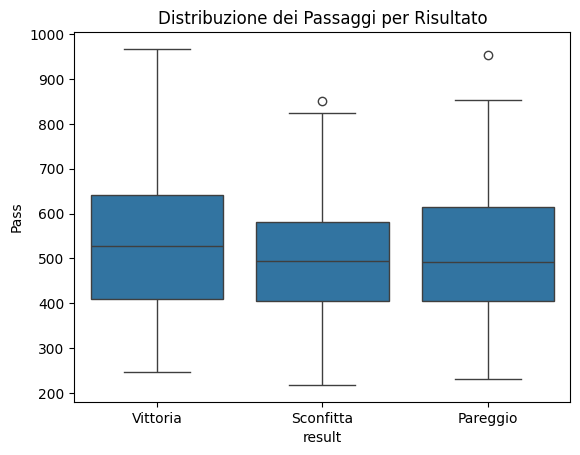

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Esempio: distribuzione dei passaggi per ciascuna classe
sns.boxplot(x='result', y='Pass', data=df_pivot)
plt.title("Distribuzione dei Passaggi per Risultato")
plt.show()

In [ ]:
#Test ANOVA: Per vedere se c'è una differenza statisticamente significativa
#nei passaggi (in questo caso) tra le tre classi

from scipy import stats

# Esempio per il numero di passaggi
groups = [group["Pass"].values for name, group in df_pivot.groupby("result")]
f_stat, p_val = stats.f_oneway(*groups)
print("ANOVA per 'Pass': F =", f_stat, ", p-value =", p_val)

#In questo caso abbiamo un p-value che ci dice che i passaggi sono statisticamente significativi
#perchè p-value < 0.05

ANOVA per 'Pass': F = 5.50213092517762 , p-value = 0.00424283768356005


In [ ]:
#Test ANOVA: Per vedere se c'è una differenza statisticamente significativa
#nei Tackle (in questo caso) tra le tre classi

from scipy import stats

# Esempio per il numero di Tackle
groups = [group["Tackle"].values for name, group in df_pivot.groupby("result")]
f_stat, p_val = stats.f_oneway(*groups)
print("ANOVA per 'Pass': F =", f_stat, ", p-value =", p_val)

#In questo caso il p-value ci dice che 'Tackle' non è statisticamente significativa
#avendo p-value > 0.05

ANOVA per 'Pass': F = 2.5600766040996628 , p-value = 0.07796793729862027


## Implementazione sistema RAG ##